In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

import multiprocessing
if __name__ == "__main__":
    multiprocessing.set_start_method("fork")
print("number of cpus =", multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

no cupy 


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


number of cpus = 12


## Load data

In [3]:
h5filename = "/Volumes/RubbishBin/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOBv4opt_TDIXYZ.h5"
with h5py.File(h5filename, "r") as h5file:
    data_dict = read_dict_from_h5(h5file["/"])
data_dict.keys()

dict_keys(['XYZ', 'time'])

In [4]:
h5paramfilename = "/Volumes/RubbishBin/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EOB4opt_parameters.h5"
with h5py.File(h5paramfilename, "r") as h5file:
    parameters = read_dict_from_h5(h5file["/"])
parameters.keys()

dict_keys(['chirp_mass', 'coalescence_phase', 'coalescence_time', 'inclination', 'latitude', 'longitude', 'luminosity_distance', 'mass_ratio', 'psi', 'spin_1z', 'spin_2z'])

In [5]:
channel_names = list(data_dict["XYZ"].keys())
data_channels = []
for ch in channel_names: 
    data_channels.append(data_dict["XYZ"][ch])
data_channels = np.array(data_channels)
data_time = data_dict["time"]
dt = data_time[1] - data_time[0]

data_time.shape, data_channels.shape 

((6294349,), (3, 6294349))

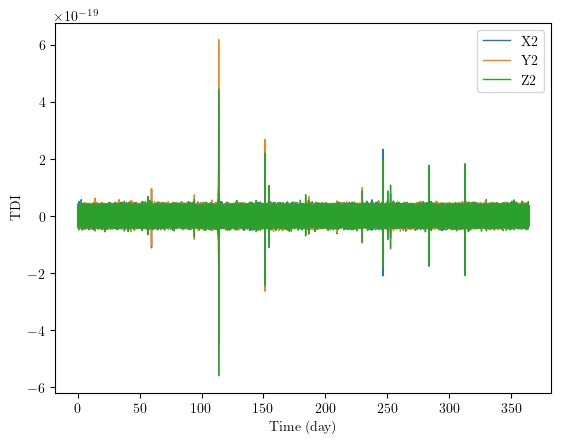

In [6]:
for ich, ch in enumerate(channel_names): 
    plt.plot(data_time/DAY, data_channels[ich], label=ch, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")

## Slice data 

In [11]:
T_analyze = 3 * DAY 
T_pad_before = 1 * DAY 
T_pad_end = 1 * DAY 

start_time = 55 * DAY 
end_time = start_time + T_analyze
start_pad_time = start_time - T_pad_before 
end_pad_time = end_time + T_pad_end 

idx_slice = np.where((data_time>=start_pad_time)&(data_time<=end_pad_time))[0]
time_slice = data_time[idx_slice]
data_slice = data_channels[:, idx_slice]

time_slice.shape, data_slice.shape 

((86401,), (3, 86401))

In [12]:
mbhb_idx = np.where((parameters["coalescence_time"]*DAY >= start_time)&(parameters["coalescence_time"]*DAY <= end_time))[0][0]
mbhb_parameters = dict()
for k, v in parameters.items():
    mbhb_parameters[k] = v[mbhb_idx]
mbhb_parameters

{'chirp_mass': 329532.86535964767,
 'coalescence_phase': 5.479530120284592,
 'coalescence_time': 56.74105804558599,
 'inclination': 0.9898451238928611,
 'latitude': 0.6912186821118975,
 'longitude': 3.3168994079772656,
 'luminosity_distance': 113926.64179360477,
 'mass_ratio': 0.4854218020719508,
 'psi': 2.962240262378551,
 'spin_1z': -0.35579,
 'spin_2z': -0.0845776}

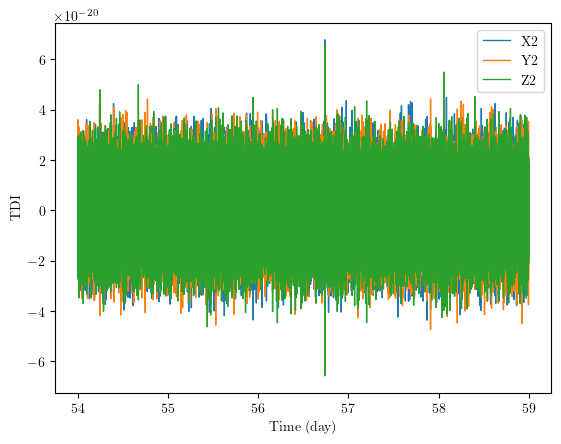

In [13]:
for ich, ch in enumerate(channel_names): 
    plt.plot(time_slice/DAY, data_slice[ich], label=ch, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")

## Signal model 

In [14]:
orbit = Orbit(OrbitDir="/Users/taijidatacenter/workspace/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB")
mbhb_waveform_generator = MBHB_Injection(approx_method="SEOBNRv4_opt", buffer=True)
mbhb_response_generator = FastMichelsonTDIResponse(
    orbit=orbit,
    tcb_times=time_slice, 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="linear",
)

In [15]:
for _ in tqdm(range(100)):
    X2temp, Y2temp, Z2temp = mbhb_response_generator(parameters=mbhb_parameters, waveform_generator=mbhb_waveform_generator, optimal_combination=False)

100%|██████████| 100/100 [00:05<00:00, 16.91it/s]


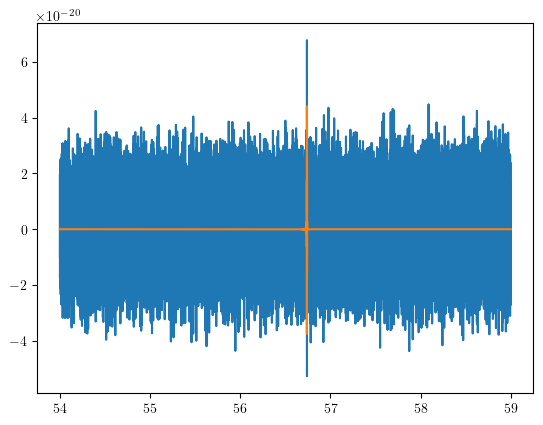

In [16]:
plt.plot(time_slice/DAY, data_slice[0])
plt.plot(time_slice/DAY, X2temp)
# plt.xlim(mbhb_parameters["coalescence_time"] - 0.1, mbhb_parameters["coalescence_time"] + 0.1)

## Matched filter

In [17]:
t_before_tc = mbhb_parameters["coalescence_time"] * DAY - DAY 
t_after_tc = mbhb_parameters["coalescence_time"] * DAY + 0.5 * DAY 
temp_idx = np.where((time_slice >= t_before_tc)&(time_slice <= t_after_tc))[0]
timetemp = time_slice[temp_idx]
X2temp = X2temp[temp_idx]
X2temp.shape 

(25920,)

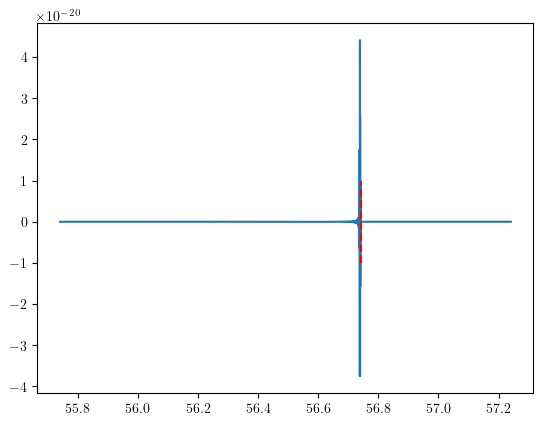

In [18]:
plt.plot(timetemp/DAY, X2temp)
plt.vlines(mbhb_parameters["coalescence_time"], -1e-20, 1e-20, color="r", linestyle="--")

In [19]:
def matched_fileter_td(data, template, dt): 
    if len(data) != len(template):
        raise ValueError("lengths mismatch.")
    # ff, xf = FFT_window(data, 1./dt, "tukey", dict(alpha=0.05))
    # _, xf1 = FFT_window(template, 1./dt, "tukey", dict(alpha=0.05))
    ff, xf = FFT_window(data, 1./dt)
    _, xf1 = FFT_window(template, 1./dt)
    df = ff[1] - ff[0]
    mask = np.ones_like(ff, dtype=bool)
    for i in range(1, 41): 
        mask_idx = np.where(np.abs(ff - i * 0.025) < 3e-4*i)[0]
        mask[mask_idx] = False 
    PSDfunc = TDIPSDs() 
    PSDdata = PSDfunc.PSD_X2(ff)
    xf = xf[mask]
    xf1 = xf1[mask]
    PSDdata = PSDdata[mask]
    MF = np.sum(np.real(np.conjugate(xf) * xf1) / PSDdata * 4. * df) 
    return MF
    

In [20]:
MFs = [] 
for idx_start in tqdm(range(len(time_slice) - len(X2temp))): 
    matching_data = data_slice[0][idx_start : idx_start + len(X2temp)]
    MFs.append(matched_fileter_td(matching_data, X2temp, dt))
MFs = np.array(MFs)

100%|██████████| 60481/60481 [00:58<00:00, 1032.26it/s]


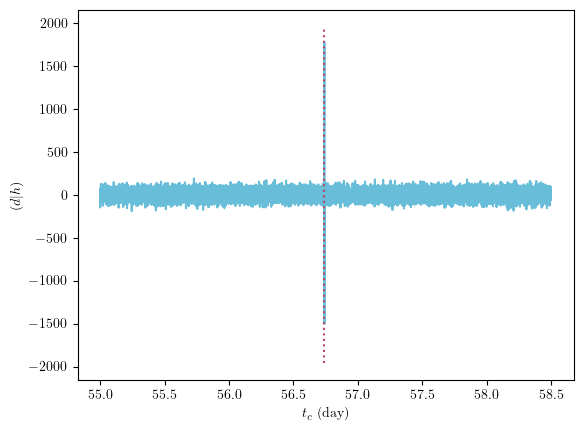

In [23]:
matching_tcs = np.arange(len(MFs)) * dt + time_slice[0] + DAY 
plt.plot(matching_tcs/DAY, MFs, color=BLUE)
plt.xlabel(r"$t_c$" + " (day)")
plt.ylabel(r"$(d|h)$")

ylim = np.max(np.abs(MFs))
plt.vlines(mbhb_parameters["coalescence_time"], -1.1 * ylim, 1.1 * ylim, linestyle=":", color=RED)
# plt.xlim(mbhb_parameters["coalescence_time"] - 0.01, mbhb_parameters["coalescence_time"] + 0.01)